In [1]:
import os

import gym
import numpy as np
import pandas as pd
import seaborn as sns

from ray import init, rllib, tune, shutdown

In [2]:
from attack_simulator.agents import DEFENDERS
from attack_simulator.env import AttackSimulationEnv
from attack_simulator.graph import AttackGraph, SIZES

In [3]:
class AgentPolicy(rllib.policy.Policy):
    def __init__(self, observation_space, action_space, config):
        super().__init__(observation_space, action_space, config)
        agent_config = dict(
            input_dim=observation_space.shape[0],
            num_actions=action_space.n,
            random_seed=config["seed"],
            attack_graph=config["env_config"]["attack_graph"],
        )
        self._agent = DEFENDERS[config["agent_type"]](agent_config)

    def compute_actions(self, observations, *args, **kwargs):
        # FIXME: use a `numpy` array as a temporary workaround for
        #        https://github.com/ray-project/ray/issues/10100
        return np.array([self._agent.act(obs) for obs in observations]), [], {}

    def get_weights(self):
        return {}

    def set_weights(self, weights):
        pass


def template_agent(agent_type):
    default_config = rllib.agents.trainer.with_common_config(dict(agent_type=agent_type))
    return rllib.agents.trainer_template.build_trainer(
        name=agent_type,
        default_policy=AgentPolicy,
        default_config=default_config,
    )

In [4]:
from copy import deepcopy


class AttackSimAlphaZeroEnv(AttackSimulationEnv):
    def set_state(self, state):
        (
            self.simulation_time,
            self.ttc_remaining,
            self.attack_surface,
            self.attack_state,
            self.service_state,
            self._observation,
            self.rng,
            self.attacker,
        ) = deepcopy(state)

    def get_state(self):
        state = (
            self.simulation_time,
            self.ttc_remaining,
            self.attack_surface,
            self.attack_state,
            self.service_state,
            self._observation,
            self.rng,
            self.attacker,
        )
        return deepcopy(state)
    

class AlphaZeroWrapper(gym.Env):
    def __init__(self, config):
        self.env = config["env_class"](config)
        self.action_space = self.env.action_space
        assert isinstance(
            self.action_space, gym.spaces.Discrete
        ), "AlphaZero requires a Discrete action space"
        shape = (self.action_space.n,)
        self.observation_space = gym.spaces.Dict(
            dict(obs=self.env.observation_space, action_mask=gym.spaces.Box(0, 1, shape))
        )
        self.reward = 0
        self.mask = np.full(shape, 1, dtype="int8")

    def reset(self):
        self.reward = 0
        observation = self.env.reset()
        return dict(obs=observation, action_mask=self.mask)

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        self.reward += reward
        reward = self.reward if done else 0
        return dict(obs=observation, action_mask=self.mask), reward, done, info

    def set_state(self, state):
        env_state, self.reward = state
        self.env.set_state(env_state)
        return dict(obs=self.env.observation, action_mask=self.mask)

    def get_state(self):
        return self.env.get_state(), self.reward

    def close(self):
        self.env.close()

    def render(self, mode=None):
        self.env.render(mode)

    def seed(self, seed=None):
        self.env.seed(seed)

In [5]:
# 'contrib/AlphaZero' does NOT appear to work without its custom dense model
from ray.rllib.contrib.alpha_zero.models.custom_torch_models import DenseModel

rllib.models.ModelCatalog.register_custom_model("alpha_zero_dense_model", DenseModel)

In [6]:
if os.path.isdir("/var/run/secrets/kubernetes.io"):  # inside k8s pod
    args = dict(address="auto")
else:
    # listen on all interfaces inside a container for port-forwarding to work
    dashboard_host = "0.0.0.0" if os.path.exists("/.dockerenv") else "127.0.0.1"
    args = dict(num_cpus=4, dashboard_host=dashboard_host)

# ALTERNATIVE: use the "Ray client" to connect to a remote cluster
# Unfortunately, JupyterNotebookReporter displays an object reference
# <IPython.core.display.HTML object> instead of content...
# --- --- ---
#
# from ray.util.client import worker
#
# worker.INITIAL_TIMEOUT_SEC = worker.MAX_TIMEOUT_SEC = 1
#
# ray_client_server = 'host.docker.internal' if os.path.exists("/.dockerenv") else '127.0.0.1'
# try:
#     init(address=f'ray://{ray_client_server}:10001')
# except Connection Error:
#     pass  # TODO: try something else...

In [7]:
agent_types = ["contrib/AlphaZero", "R2D2", "rule-based", "random"]
graphs = [AttackGraph(dict(graph_size=size)) for size in SIZES]
seeds = [0, 1, 2, 3, 6, 7, 11, 28, 42, 1337]
iterations = 1 # 10
rollouts = 5
train = True

base_config = dict(
    # log_level='DEBUG',
    framework="torch",
    env=AttackSimulationEnv,
    env_config=dict(attack_graph=tune.grid_search(graphs)),
    seed=tune.grid_search(seeds),
    num_workers=2,
)
eval_config = dict(
    evaluation_num_workers=1,
    evaluation_config=dict(
        explore=False,
        # workaround for a bug in RLLib (https://github.com/ray-project/ray/issues/17921)
        replay_sequence_length=-1,
    ),
    evaluation_num_episodes=rollouts,
    # evaluation ONLY: avoid MultiGPU optimizer, set all relevant sizes to 0
    simple_optimizer=True,
    num_workers=0,
    train_batch_size=0,
    rollout_fragment_length=0,
    timesteps_per_iteration=0,
    # evaluation at the end
    evaluation_interval=1,
)

AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)
AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)
AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)
AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)
AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)
AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)
AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)


In [8]:
rename = {
    "config.env_config.agent_type": "Agent",
    "config.env_config.attack_graph": "graph",
    "evaluation.hist_stats.episode_reward": "returns",
    "evaluation.hist_stats.episode_lengths": "lengths",
}

def postprocess(results_df):
    df = results_df[rename.keys()].rename(columns=rename)
    df.dropna(inplace=True)  # remove `NaN` evaluation results from failed trials 
    df["Graph size"] = df["graph"].apply(lambda g: g.num_attacks)
    del df["graph"]
    df["tuple"] = df.apply(lambda t: list(zip(t.returns, t.lengths)), axis="columns")
    del df["returns"]
    del df["lengths"]
    df = df.explode("tuple", ignore_index=True)
    df[["Returns", "Episode lengths"]] = df["tuple"].tolist()
    del df["tuple"]
    return df

In [9]:
class SilentReporter(tune.ProgressReporter):
    def should_report(*args, **kwargs):
        return False
    def report(*args, **kwargs):
        pass
    
quiet = SilentReporter()

In [10]:
def generate(savename):
    init(**args)

    frames = []
    for agent_type in agent_types:
        config = dict(base_config)
        config["env_config"].update(agent_type=agent_type)

        if agent_type in DEFENDERS:
            agent = template_agent(agent_type)
            resume = False
        else:
            agent = agent_type
            if agent_type == "contrib/AlphaZero":
                config.update(
                    env=AlphaZeroWrapper,
                    model=dict(custom_model="alpha_zero_dense_model"),
                    rollout_fragment_length=32,
                    train_batch_size=640,
                    buffer_size=512,
                )
                config["env_config"].update(env_class=AttackSimAlphaZeroEnv)
            else:
                config.update(model=dict(use_lstm=True))
            # TRAINING
            if train:
                tune.run(
                    agent,
                    config=config,
                    stop=dict(training_iteration=iterations), # TODO: additional stopping criteria?
                    checkpoint_at_end=True,
                    max_failures=3,
                    #queue_trials=True,
                    raise_on_failed_trial=False,
                    progress_reporter=quiet,  # tune.JupyterNotebookReporter(overwrite=True),
                    verbose=0,
                )
            resume = True

        # EVALUATION
        config.update(eval_config)
        print(resume, config)
        results = tune.run(
            agent,
            config=config,
            resume=resume,
            stop=dict(training_iteration=0),
            max_failures=3,
            #queue_trials=True,
            raise_on_failed_trial=False,
            progress_reporter=quiet,  # tune.JupyterNotebookReporter(overwrite=True),
            verbose=0,
        )
        frame = results.results_df
        print('\n'.join(frame.columns))
        frames.append(frame)

    shutdown()
    results_df = pd.concat(frames, ignore_index=True)
    df = postprocess(results_df)
    df.to_csv(savename)
    return df

In [11]:
savename = "returns-tune-split.csv"

df = generate(savename) if not os.path.exists(savename) else pd.read_csv(savename, index_col=0)

2021-10-08 00:59:22,434	INFO services.py:1263 -- View the Ray dashboard at http://172.17.0.3:8265
(pid=31613) 2021-10-08 00:59:24,292	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
(pid=31613) 2021-10-08 00:59:24,292	INFO trainer.py:726 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-10-08 00:59:29,665	INFO logger.py:697 -- Removed the following hyperparameter values when logging to tensorboard: {'env_config/attack_graph': <attack_simulator.graph.AttackGraph object at 0xffff84d97f10>}
(pid=31612) 2021-10-08 00:59:31,168	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
(pid=31612) 2021-10-08 00:59:31,168	INFO trainer.py:726 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-10-08 00:59:37,

True {'framework': 'torch', 'env': <class '__main__.AlphaZeroWrapper'>, 'env_config': {'attack_graph': {'grid_search': [<attack_simulator.graph.AttackGraph object at 0xffff6e3d08e0>, <attack_simulator.graph.AttackGraph object at 0xffff6e3e09d0>, <attack_simulator.graph.AttackGraph object at 0xffff6e386040>, <attack_simulator.graph.AttackGraph object at 0xffff6e38bd00>, <attack_simulator.graph.AttackGraph object at 0xffff6e329310>, <attack_simulator.graph.AttackGraph object at 0xffff6e39ab80>, <attack_simulator.graph.AttackGraph object at 0xffff6e39a940>]}, 'agent_type': 'contrib/AlphaZero', 'env_class': <class '__main__.AttackSimAlphaZeroEnv'>}, 'seed': {'grid_search': [0, 1, 2, 3, 6, 7, 11, 28, 42, 1337]}, 'num_workers': 0, 'model': {'custom_model': 'alpha_zero_dense_model'}, 'rollout_fragment_length': 0, 'train_batch_size': 0, 'buffer_size': 512, 'evaluation_num_workers': 1, 'evaluation_config': {'explore': False, 'replay_sequence_length': -1}, 'evaluation_num_episodes': 5, 'simple_o

2021-10-08 01:09:36,733	INFO tune.py:484 -- TrialRunner resumed, ignoring new add_experiment.


episode_reward_max
episode_reward_min
episode_reward_mean
episode_len_mean
episodes_this_iter
num_healthy_workers
timesteps_total
agent_timesteps_total
done
episodes_total
training_iteration
experiment_id
date
timestamp
time_this_iter_s
time_total_s
pid
hostname
node_ip
time_since_restore
timesteps_since_restore
iterations_since_restore
experiment_tag
hist_stats.episode_reward
hist_stats.episode_lengths
sampler_perf.mean_raw_obs_processing_ms
sampler_perf.mean_inference_ms
sampler_perf.mean_action_processing_ms
sampler_perf.mean_env_wait_ms
sampler_perf.mean_env_render_ms
timers.sample_time_ms
timers.sample_throughput
timers.learn_time_ms
timers.learn_throughput
timers.update_time_ms
info.num_steps_sampled
info.num_agent_steps_sampled
info.num_steps_trained
config.num_workers
config.num_envs_per_worker
config.create_env_on_driver
config.rollout_fragment_length
config.batch_mode
config.gamma
config.lr
config.train_batch_size
config.horizon
config.soft_horizon
config.no_done_at_end
confi

(pid=37492) 2021-10-08 01:09:39,145	INFO trainer.py:726 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-10-08 01:09:41,458	INFO logger.py:697 -- Removed the following hyperparameter values when logging to tensorboard: {'env_config/attack_graph': <attack_simulator.graph.AttackGraph object at 0xfffea2f780d0>}
(pid=37570) 2021-10-08 01:09:42,936	INFO trainer.py:726 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-10-08 01:09:45,234	INFO logger.py:697 -- Removed the following hyperparameter values when logging to tensorboard: {'env_config/attack_graph': <attack_simulator.graph.AttackGraph object at 0xfffea29b7d90>}
(pid=37646) 2021-10-08 01:09:46,754	INFO trainer.py:726 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-10-08 01:09:49,066	INFO logger.py:697 -- Removed the following

True {'framework': 'torch', 'env': <class 'attack_simulator.env.AttackSimulationEnv'>, 'env_config': {'attack_graph': {'grid_search': [<attack_simulator.graph.AttackGraph object at 0xffff6e3d08e0>, <attack_simulator.graph.AttackGraph object at 0xffff6e3e09d0>, <attack_simulator.graph.AttackGraph object at 0xffff6e386040>, <attack_simulator.graph.AttackGraph object at 0xffff6e38bd00>, <attack_simulator.graph.AttackGraph object at 0xffff6e329310>, <attack_simulator.graph.AttackGraph object at 0xffff6e39ab80>, <attack_simulator.graph.AttackGraph object at 0xffff6e39a940>]}, 'agent_type': 'R2D2', 'env_class': <class '__main__.AttackSimAlphaZeroEnv'>}, 'seed': {'grid_search': [0, 1, 2, 3, 6, 7, 11, 28, 42, 1337]}, 'num_workers': 0, 'model': {'use_lstm': True}, 'evaluation_num_workers': 1, 'evaluation_config': {'explore': False, 'replay_sequence_length': -1}, 'evaluation_num_episodes': 5, 'simple_optimizer': True, 'train_batch_size': 0, 'rollout_fragment_length': 0, 'timesteps_per_iteration'

2021-10-08 01:14:05,466	INFO tune.py:484 -- TrialRunner resumed, ignoring new add_experiment.


episode_reward_max
episode_reward_min
episode_reward_mean
episode_len_mean
episodes_this_iter
num_healthy_workers
timesteps_total
agent_timesteps_total
done
episodes_total
training_iteration
experiment_id
date
timestamp
time_this_iter_s
time_total_s
pid
hostname
node_ip
time_since_restore
timesteps_since_restore
iterations_since_restore
experiment_tag
hist_stats.episode_reward
hist_stats.episode_lengths
sampler_perf.mean_raw_obs_processing_ms
sampler_perf.mean_inference_ms
sampler_perf.mean_action_processing_ms
sampler_perf.mean_env_wait_ms
sampler_perf.mean_env_render_ms
timers.load_time_ms
timers.load_throughput
timers.learn_time_ms
timers.learn_throughput
timers.update_time_ms
info.num_steps_sampled
info.num_agent_steps_sampled
info.num_steps_trained
info.num_agent_steps_trained
info.last_target_update_ts
config.num_workers
config.num_envs_per_worker
config.create_env_on_driver
config.rollout_fragment_length
config.batch_mode
config.gamma
config.lr
config.train_batch_size
config.hor

(pid=42908) 2021-10-08 01:14:08,482	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
(pid=42908) 2021-10-08 01:14:08,482	INFO trainer.py:726 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=42908) 2021-10-08 01:14:08,485	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
(pid=42909) 2021-10-08 01:14:08,482	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
(pid=42909) 2021-10-08 01:14:08,482	INFO trainer.py:726 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=42909) 2021-10-08 01:14:08,485	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future

episode_reward_max
episode_reward_min
episode_reward_mean
episode_len_mean
episodes_this_iter
num_healthy_workers
timesteps_total
agent_timesteps_total
done
episodes_total
training_iteration
experiment_id
date
timestamp
time_this_iter_s
time_total_s
pid
hostname
node_ip
time_since_restore
timesteps_since_restore
iterations_since_restore
experiment_tag
hist_stats.episode_reward
hist_stats.episode_lengths
timers.sample_time_ms
timers.sample_throughput
timers.learn_time_ms
timers.learn_throughput
info.num_steps_sampled
info.num_agent_steps_sampled
info.num_steps_trained
info.num_agent_steps_trained
evaluation.episode_reward_max
evaluation.episode_reward_min
evaluation.episode_reward_mean
evaluation.episode_len_mean
evaluation.episodes_this_iter
config.num_workers
config.num_envs_per_worker
config.create_env_on_driver
config.rollout_fragment_length
config.batch_mode
config.gamma
config.lr
config.train_batch_size
config.horizon
config.soft_horizon
config.no_done_at_end
config.env
config.obs

(pid=46473) 2021-10-08 01:15:57,798	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
(pid=46473) 2021-10-08 01:15:57,798	INFO trainer.py:726 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=46473) 2021-10-08 01:15:57,802	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
(pid=46474) 2021-10-08 01:15:57,784	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
(pid=46474) 2021-10-08 01:15:57,784	INFO trainer.py:726 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=46474) 2021-10-08 01:15:57,787	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future

episode_reward_max
episode_reward_min
episode_reward_mean
episode_len_mean
episodes_this_iter
num_healthy_workers
timesteps_total
agent_timesteps_total
done
episodes_total
training_iteration
experiment_id
date
timestamp
time_this_iter_s
time_total_s
pid
hostname
node_ip
time_since_restore
timesteps_since_restore
iterations_since_restore
experiment_tag
hist_stats.episode_reward
hist_stats.episode_lengths
timers.sample_time_ms
timers.sample_throughput
timers.learn_time_ms
timers.learn_throughput
info.num_steps_sampled
info.num_agent_steps_sampled
info.num_steps_trained
info.num_agent_steps_trained
evaluation.episode_reward_max
evaluation.episode_reward_min
evaluation.episode_reward_mean
evaluation.episode_len_mean
evaluation.episodes_this_iter
config.num_workers
config.num_envs_per_worker
config.create_env_on_driver
config.rollout_fragment_length
config.batch_mode
config.gamma
config.lr
config.train_batch_size
config.horizon
config.soft_horizon
config.no_done_at_end
config.env
config.obs

In [12]:
sns.set(style="darkgrid", rc={"figure.figsize": (12, 8)})

Text(0.5, 1.0, 'Returns vs Size (random attacker)')

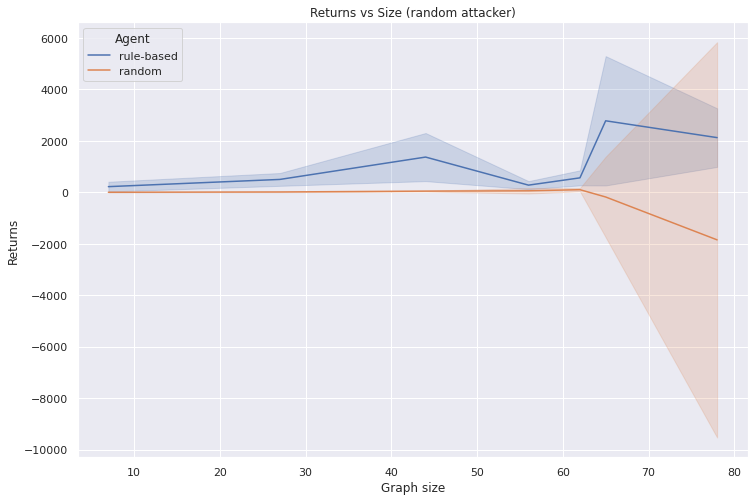

In [13]:
g = sns.lineplot(data=df, x="Graph size", y="Returns", hue="Agent", ci="sd")
g.legend(title="Agent", loc="upper left")
g.set_title("Returns vs Size (random attacker)")

Text(0.5, 1.0, 'Episode lengths vs Size (random attacker)')

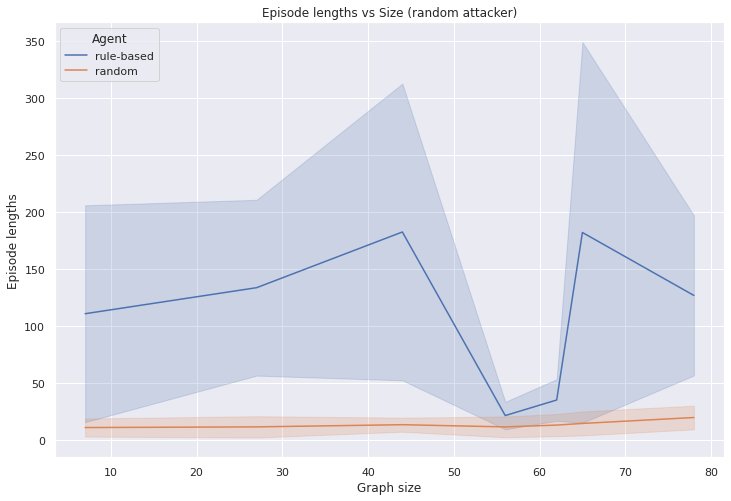

In [14]:
g = sns.lineplot(data=df, x="Graph size", y="Episode lengths", hue="Agent", ci="sd")
g.legend(title="Agent", loc="upper left")
g.set_title("Episode lengths vs Size (random attacker)")

In [15]:
# pd.set_option("display.max_columns", 32)
df.groupby("Agent").describe()

Graph size                                                    \
                count       mean       std  min   25%   50%   75%   max   
Agent                                                                     
random          350.0  48.428571  22.66523  7.0  27.0  56.0  65.0  78.0   
rule-based      350.0  48.428571  22.66523  7.0  27.0  56.0  65.0  78.0   

           Returns               ...                   Episode lengths  \
             count         mean  ...      75%      max           count   
Agent                            ...                                     
random       350.0  -257.765714  ...   108.75    234.0           350.0   
rule-based   350.0  1119.808571  ...  1467.50  11668.0           350.0   

                                                                    
                  mean         std  min   25%   50%     75%    max  
Agent                                                               
random       13.657143    9.459135  3.0   7.0  11.0   17.75   51.0  
rule-based  113.211429  112.529224  6.0  33.0  80.0  149.75  775.0  

[2 rows x 24 columns]